# **L&T EduTech Hackathon at SHAASTRA IITM**

### **Problem Statement 3:**
Description: Natural disasters and atmospheric anomalies demand remote monitoring and maintenance of naval objects especially big-size ships. For example, under poor weather conditions, prior knowledge about the ship model and type helps the automatic docking system process to be smooth. Thus, this set aims to classify the type of ships from an image data set of ships.

###**Requirement Specification:**
1.   Design transfer learning-based CNN architecture to classify the data set
2.   Identify an optimal training data size in percentage

### **Judging Metrics:** Kappa score

###**Dataset Description:**
There are 6252 images in train and 2680 images in test data. The categories of ships and their corresponding codes in the dataset are as follows -

There are 5 classes of ships to be detected which are as follows:


1.   Cargo
2.   Military
3.   Carrier
4.   Cruise
5.   Tankers





### Importing required python libraries

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input


from PIL import Image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator  # Used for image augmentation
from numpy import expand_dims

!pip install opendatasets
import opendatasets as od  # To download dataset from kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download ship dataset from kaggle.
# This requires kaggle account username and key, we can enter it by running this cell or 
# it will get automatically read by notebook if kaggle.json file (provided) stored in the same folder (content folder in colab) as python is running.

od.download('https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets/code')

100%|██████████| 80.9M/80.9M [00:00<00:00, 135MB/s]


### Loading Dataset
Now we will load dataset with the help of pandas.
As the ship dataset is downloaded in content folder, accordingly we will give paths.

In [3]:
dataset_path = r'/content/game-of-deep-learning-ship-datasets'  # main data folder path
train_path = os.path.join(dataset_path, 'train')
images_path = os.path.join(train_path, 'images')
test_csv = os.path.join(dataset_path, 'test_ApKoW4T.csv')
train_csv = os.path.join(train_path, 'train.csv')

test_df = pd.read_csv(test_csv)
train_df = pd.read_csv(train_csv) # it contains image names and their respective labels

num_test_img = len(test_df)
num_train_img = len(train_df)

print(f'Total Number of test images: {num_test_img}')
print(f'Total Number of train images: {num_train_img}')

Total Number of test images: 2680
Total Number of train images: 6252


In [4]:
main_path = "/content/game-of-deep-learning-ship-datasets/train/images/"   # it contains all the images
main_df = pd.read_csv(r'/content/game-of-deep-learning-ship-datasets/train/train.csv')
paths = os.listdir(main_path)
main_df['path'] = main_path + main_df['image']    # In the path column, paths of all images saved.

categories = list(main_df['category'])   # Saves list of ship categories.
categorys = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}

In [5]:
classes = []
for category in categories:
    classes.append(categorys[category])         # Ship category is saved in classes sequencially.


main_df['classes'] = classes
test_df = pd.read_csv(r'/content/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')
test_df['path'] = main_path + test_df['image']

Let's have a look at our dataset.

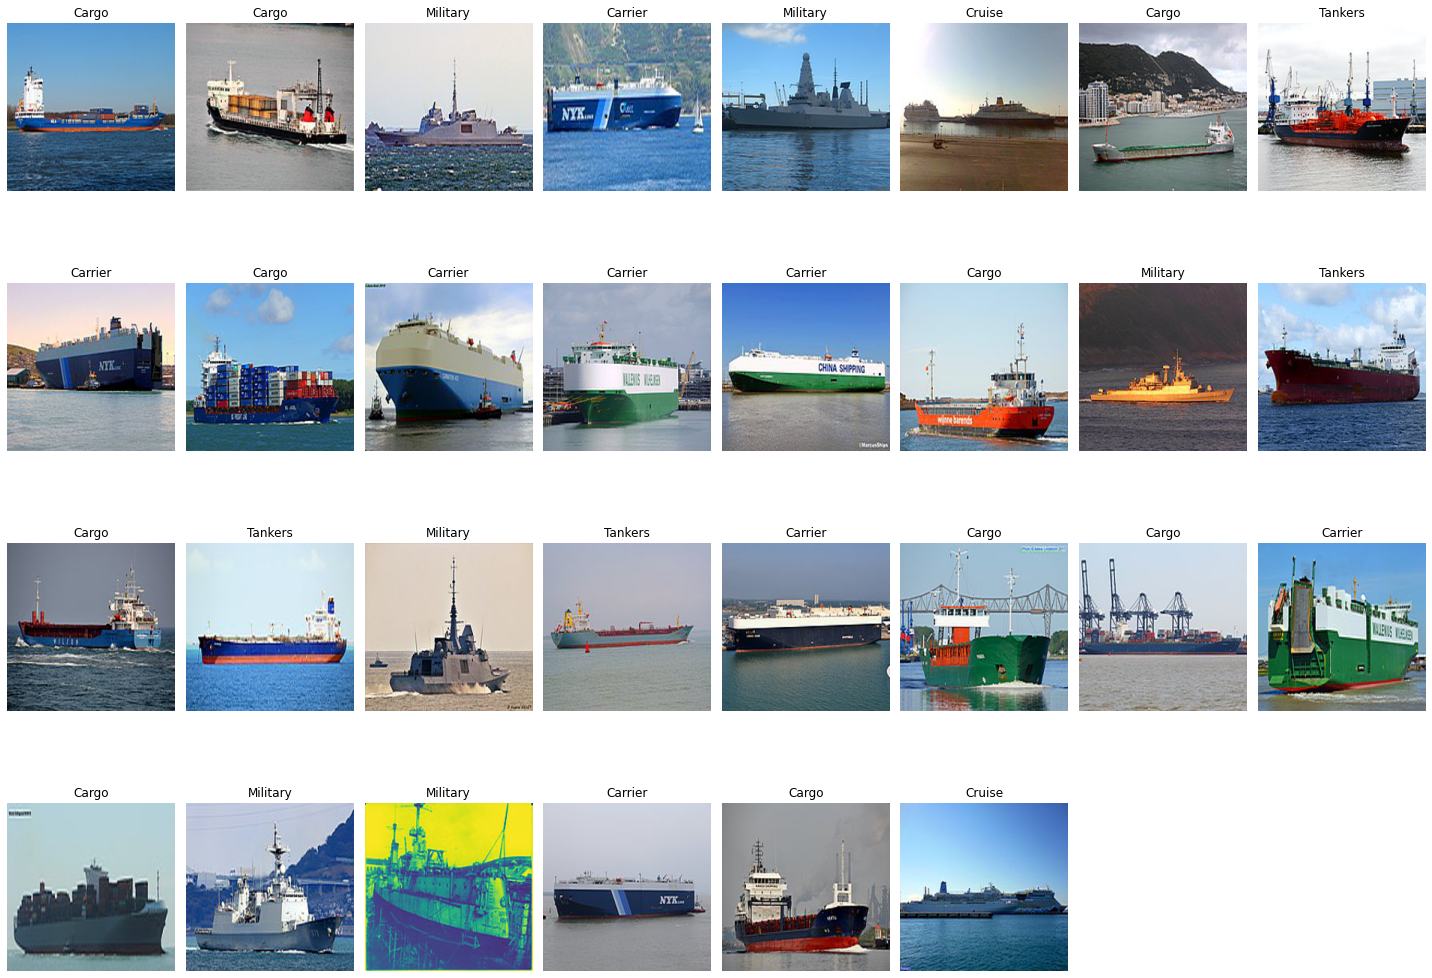

In [6]:
plt.figure(figsize = (20,15))
for i ,image_path in enumerate(main_df['path']):
    if i==30:
        break
    plt.subplot(4,8,i+1)
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(main_df['classes'][i])
plt.tight_layout()
plt.show()

Here we have saved each image dimensions.

In [7]:
widths, heights = [], []

for path in tqdm(main_df["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)
    
main_df["width"] = widths
main_df["height"] = heights
main_df["dimension"] = main_df["width"] * main_df["height"]

100%|██████████| 6252/6252 [00:00<00:00, 7820.04it/s]


As imbalanced dataset affects the classification accuracy, we will look the class distribution.

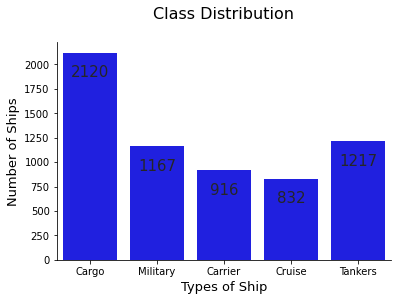

In [8]:
plot = sns.countplot(x = main_df['classes'], color = 'b')
sns.set(rc={'figure.figsize':(10,8)})
sns.despine()
plot.set_title('Class Distribution\n', fontsize = 16);
plot.set_ylabel("Number of Ships", fontsize=13)
plot.set_xlabel("Types of Ship", fontsize=13)

for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center',
                  va = 'center', xytext = (0, -20), textcoords = 'offset points', size = 15)

Let's have a look how the dataframe with all details look like.

In [9]:
main_df.head()

,image,category,path,classes,width,height,dimension
0,2823080.jpg,1,/content/game-of-deep-learning-ship-datasets/t...,Cargo,210,140,29400
1,2870024.jpg,1,/content/game-of-deep-learning-ship-datasets/t...,Cargo,210,139,29190
2,2662125.jpg,2,/content/game-of-deep-learning-ship-datasets/t...,Military,210,118,24780
3,2900420.jpg,3,/content/game-of-deep-learning-ship-datasets/t...,Carrier,210,88,18480
4,2804883.jpg,2,/content/game-of-deep-learning-ship-datasets/t...,Military,210,158,33180


Now, as per the given problem statement, the first goal is to design a transfer learning-based CNN architecture. There are many pretrained models available in the Keras library. Here I have compared five pretrained models, and we will select the best among them. To select the best among them, I have considered the weighted F1 score as a metric, as the problem is an imbalanced multi-class classification problem.

Pretained models:


1.   MobilenetV2
2.   Resnet152V2
3.   Efficientnet
4.   VGG19
5.   Xception



For comparison purposes, we will split the data into training, validation, and testing categories. We will use the same outer architecture for each pretrained model.

In [10]:
X, y = main_df[['path', 'classes']], main_df['classes']

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  # 10% test data
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)  # From the remaining 90% data, 20% is validation data.

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (4500, 2)
y_train shape:  (4500,)
X_val shape  :  (1126, 2)
y_val shape  :  (1126,)
X_test shape :  (626, 2)
y_test shape :  (626,)


## Data Augmentation

We will use ImageDatagenerator() here, it return images after doing various augmenting techniques, and it does not add to original dataset. The size of the dataset remains same.

As all images are in same folder, we will use flow_from_dataframe() here.

In [11]:
datagen = ImageDataGenerator(rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
) 


train_generator = datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator = datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator = datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
)

Found 4500 validated image filenames belonging to 5 classes.
Found 1126 validated image filenames belonging to 5 classes.
Found 626 validated image filenames belonging to 5 classes.


## MobileNetV2

In [12]:
IMG_SHAPE = (224,224,3)
mobilenetv2_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
model_mobilenetv2 = tf.keras.Sequential([
  mobilenetv2_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
history_mobilenetv2 = model_mobilenetv2.fit(
      train_generator,
      validation_data=val_generator,
      epochs=20,
      verbose=2)

model_mobilenetv2.save('model_mobilenetv2.h5')

Epoch 1/20
141/141 - 95s - loss: 0.5869 - accuracy: 0.7773 - val_loss: 2.2212 - val_accuracy: 0.4822 - 95s/epoch - 676ms/step
Epoch 2/20
141/141 - 81s - loss: 0.2810 - accuracy: 0.8951 - val_loss: 1.2693 - val_accuracy: 0.6679 - 81s/epoch - 571ms/step
Epoch 3/20
141/141 - 80s - loss: 0.2021 - accuracy: 0.9271 - val_loss: 1.0338 - val_accuracy: 0.7469 - 80s/epoch - 565ms/step
Epoch 4/20
141/141 - 79s - loss: 0.1747 - accuracy: 0.9347 - val_loss: 1.1335 - val_accuracy: 0.7549 - 79s/epoch - 558ms/step
Epoch 5/20
141/141 - 80s - loss: 0.1332 - accuracy: 0.9491 - val_loss: 0.6167 - val_accuracy: 0.8472 - 80s/epoch - 565ms/step
Epoch 6/20
141/141 - 79s - loss: 0.1104 - accuracy: 0.9564 - val_loss: 0.5663 - val_accuracy: 0.8632 - 79s/epoch - 558ms/step
Epoch 7/20
141/141 - 79s - loss: 0.0965 - accuracy: 0.9627 - val_loss: 0.7635 - val_accuracy: 0.8410 - 79s/epoch - 557ms/step
Epoch 8/20
141/141 - 79s - loss: 0.0781 - accuracy: 0.9756 - val_loss: 0.5057 - val_accuracy: 0.8694 - 79s/epoch - 559

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn import metrics
ship_labels = ['Cargo','Carrier','Cruise','Military','Tankers']

In [16]:
# Predicting labels from X_test data
y_pred_mobilenetv2 = model_mobilenetv2.predict(test_generator)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_mobilenetv2 = np.argmax(y_pred_mobilenetv2, axis = 1)

print('\n Classification Report:\n',classification_report(test_generator.classes, y_pred_mobilenetv2))

print("\nAccuracy:",metrics.accuracy_score(test_generator.classes, y_pred_mobilenetv2))

20/20 [==============================] - 9s 418ms/step

 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       201
           1       0.99      0.99      0.99        95
           2       0.95      0.98      0.96        82
           3       0.97      0.97      0.97       112
           4       0.93      0.79      0.86       136

    accuracy                           0.93       626
   macro avg       0.94      0.93      0.94       626
weighted avg       0.93      0.93      0.93       626


Accuracy: 0.9265175718849841


## ResNet152V2

In [17]:
from keras.applications.resnet_v2 import ResNet152V2
resnet_152_v2_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

234545216/234545216 [==============================] - 1s 0us/step


In [18]:
model_resnet152v2 = tf.keras.Sequential([
  resnet_152_v2_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model_resnet152v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
history_resnet152v2 = model_resnet152v2.fit(
      train_generator,
      validation_data=val_generator,
      epochs=20,
      verbose=2)

model_resnet152v2.save('model_resnet152v2.h5')

Epoch 1/20
141/141 - 147s - loss: 0.5597 - accuracy: 0.7978 - val_loss: 0.6800 - val_accuracy: 0.7895 - 147s/epoch - 1s/step
Epoch 2/20
141/141 - 124s - loss: 0.2544 - accuracy: 0.9082 - val_loss: 0.3372 - val_accuracy: 0.9050 - 124s/epoch - 883ms/step
Epoch 3/20
141/141 - 123s - loss: 0.2148 - accuracy: 0.9236 - val_loss: 0.3646 - val_accuracy: 0.8845 - 123s/epoch - 875ms/step
Epoch 4/20
141/141 - 124s - loss: 0.1689 - accuracy: 0.9400 - val_loss: 0.3587 - val_accuracy: 0.8872 - 124s/epoch - 876ms/step
Epoch 5/20
141/141 - 123s - loss: 0.1422 - accuracy: 0.9487 - val_loss: 0.2835 - val_accuracy: 0.9076 - 123s/epoch - 873ms/step
Epoch 6/20
141/141 - 123s - loss: 0.1184 - accuracy: 0.9600 - val_loss: 0.2656 - val_accuracy: 0.9121 - 123s/epoch - 875ms/step
Epoch 7/20
141/141 - 123s - loss: 0.1176 - accuracy: 0.9611 - val_loss: 0.3338 - val_accuracy: 0.8952 - 123s/epoch - 874ms/step
Epoch 8/20
141/141 - 124s - loss: 0.1124 - accuracy: 0.9662 - val_loss: 0.3433 - val_accuracy: 0.8845 - 124

In [20]:
# Predicting labels from X_test data
y_pred_resnet152v2 = model_resnet152v2.predict(test_generator)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_resnet152v2 = np.argmax(y_pred_resnet152v2, axis = 1)

print('\n Classification Report:\n',classification_report(test_generator.classes, y_pred_resnet152v2))

print("\nAccuracy:",metrics.accuracy_score(test_generator.classes, y_pred_resnet152v2))

20/20 [==============================] - 12s 503ms/step

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87       201
           1       0.87      0.99      0.93        95
           2       0.98      0.96      0.97        82
           3       0.92      0.92      0.92       112
           4       0.83      0.82      0.83       136

    accuracy                           0.89       626
   macro avg       0.90      0.91      0.90       626
weighted avg       0.89      0.89      0.89       626


Accuracy: 0.8929712460063898


## EfficientNet

In [21]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.2 MB/s eta 0:00:00


In [22]:
import efficientnet.keras as effnet

efficientnet_model = effnet.EfficientNetB5(weights='imagenet', input_shape=IMG_SHAPE, include_top=False)

115515256/115515256 [==============================] - 2s 0us/step


In [23]:
model_efficientnetb5 = tf.keras.Sequential([
  efficientnet_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model_efficientnetb5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [24]:
history_efficientnetb5 = model_efficientnetb5.fit(
      train_generator,
      validation_data=val_generator,
      epochs=20,
      verbose=2)

model_efficientnetb5.save('model_efficientnetb5.h5')

Epoch 1/20
141/141 - 188s - loss: 0.6770 - accuracy: 0.7316 - val_loss: 0.3790 - val_accuracy: 0.8570 - 188s/epoch - 1s/step
Epoch 2/20
141/141 - 165s - loss: 0.3140 - accuracy: 0.8902 - val_loss: 0.2499 - val_accuracy: 0.9130 - 165s/epoch - 1s/step
Epoch 3/20
141/141 - 161s - loss: 0.2395 - accuracy: 0.9149 - val_loss: 0.2021 - val_accuracy: 0.9236 - 161s/epoch - 1s/step
Epoch 4/20
141/141 - 161s - loss: 0.1765 - accuracy: 0.9376 - val_loss: 0.1937 - val_accuracy: 0.9272 - 161s/epoch - 1s/step
Epoch 5/20
141/141 - 161s - loss: 0.1354 - accuracy: 0.9509 - val_loss: 0.2143 - val_accuracy: 0.9245 - 161s/epoch - 1s/step
Epoch 6/20
141/141 - 161s - loss: 0.1181 - accuracy: 0.9567 - val_loss: 0.2018 - val_accuracy: 0.9263 - 161s/epoch - 1s/step
Epoch 7/20
141/141 - 161s - loss: 0.0930 - accuracy: 0.9678 - val_loss: 0.1982 - val_accuracy: 0.9369 - 161s/epoch - 1s/step
Epoch 8/20
141/141 - 161s - loss: 0.0779 - accuracy: 0.9722 - val_loss: 0.2037 - val_accuracy: 0.9369 - 161s/epoch - 1s/step


In [25]:
# Predicting labels from X_test data
y_pred_efficientnetb5 = model_efficientnetb5.predict(test_generator)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_efficientnetb5 = np.argmax(y_pred_efficientnetb5, axis = 1)

print('\n Classification Report:\n',classification_report(test_generator.classes, y_pred_efficientnetb5))

print("\nAccuracy:",metrics.accuracy_score(test_generator.classes, y_pred_efficientnetb5))

20/20 [==============================] - 13s 502ms/step

 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       201
           1       0.97      0.99      0.98        95
           2       0.96      0.95      0.96        82
           3       0.94      0.96      0.95       112
           4       0.84      0.91      0.87       136

    accuracy                           0.92       626
   macro avg       0.93      0.93      0.93       626
weighted avg       0.92      0.92      0.92       626


Accuracy: 0.9201277955271565


## VGG19

In [27]:
from keras.applications.vgg19 import VGG19
vgg19_model = VGG19(weights='imagenet',include_top=False, input_shape=IMG_SHAPE)

80134624/80134624 [==============================] - 0s 0us/step


In [28]:
model_vgg19 = tf.keras.Sequential([
  vgg19_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [29]:
history_vgg19 = model_vgg19.fit(
      train_generator,
      validation_data=val_generator,
      epochs=20,
      verbose=2)

model_vgg19.save('model_vgg19.h5')

Epoch 1/20
141/141 - 103s - loss: 1.6073 - accuracy: 0.3367 - val_loss: 1.5068 - val_accuracy: 0.3384 - 103s/epoch - 730ms/step
Epoch 2/20
141/141 - 92s - loss: 1.3568 - accuracy: 0.4118 - val_loss: 1.1342 - val_accuracy: 0.4920 - 92s/epoch - 654ms/step
Epoch 3/20
141/141 - 92s - loss: 0.9959 - accuracy: 0.5876 - val_loss: 0.9367 - val_accuracy: 0.6119 - 92s/epoch - 655ms/step
Epoch 4/20
141/141 - 92s - loss: 0.7729 - accuracy: 0.6993 - val_loss: 0.6095 - val_accuracy: 0.7815 - 92s/epoch - 653ms/step
Epoch 5/20
141/141 - 93s - loss: 0.5867 - accuracy: 0.7818 - val_loss: 0.6378 - val_accuracy: 0.7611 - 93s/epoch - 658ms/step
Epoch 6/20
141/141 - 92s - loss: 0.4837 - accuracy: 0.8256 - val_loss: 0.4687 - val_accuracy: 0.8206 - 92s/epoch - 653ms/step
Epoch 7/20
141/141 - 92s - loss: 0.4066 - accuracy: 0.8500 - val_loss: 0.4083 - val_accuracy: 0.8552 - 92s/epoch - 652ms/step
Epoch 8/20
141/141 - 92s - loss: 0.3468 - accuracy: 0.8773 - val_loss: 0.3485 - val_accuracy: 0.8748 - 92s/epoch - 6

In [30]:
# Predicting labels from X_test data
y_pred_vgg19 = model_vgg19.predict(test_generator)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_vgg19 = np.argmax(y_pred_vgg19, axis = 1)

print('\n Classification Report:\n',classification_report(test_generator.classes, y_pred_vgg19))

print("\nAccuracy:",metrics.accuracy_score(test_generator.classes, y_pred_vgg19))

20/20 [==============================] - 10s 514ms/step

 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       201
           1       0.98      0.97      0.97        95
           2       0.86      0.93      0.89        82
           3       0.96      0.73      0.83       112
           4       0.77      0.85      0.80       136

    accuracy                           0.86       626
   macro avg       0.88      0.87      0.87       626
weighted avg       0.87      0.86      0.86       626


Accuracy: 0.8578274760383386


## Xception

In [31]:
from tensorflow.keras.applications.xception import Xception

xception_model = Xception(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

83683744/83683744 [==============================] - 1s 0us/step


In [32]:
model_xception = tf.keras.Sequential([
  xception_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [33]:
history_xception = model_xception.fit(
      train_generator,
      validation_data=val_generator,
      epochs=20,
      verbose=2)

model_xception.save('model_xception.h5')

Epoch 1/20
141/141 - 109s - loss: 0.5319 - accuracy: 0.7949 - val_loss: 0.3705 - val_accuracy: 0.8819 - 109s/epoch - 772ms/step
Epoch 2/20
141/141 - 100s - loss: 0.2225 - accuracy: 0.9218 - val_loss: 0.2461 - val_accuracy: 0.9147 - 100s/epoch - 709ms/step
Epoch 3/20
141/141 - 100s - loss: 0.1522 - accuracy: 0.9444 - val_loss: 0.2703 - val_accuracy: 0.9130 - 100s/epoch - 710ms/step
Epoch 4/20
141/141 - 100s - loss: 0.0996 - accuracy: 0.9616 - val_loss: 0.2445 - val_accuracy: 0.9183 - 100s/epoch - 707ms/step
Epoch 5/20
141/141 - 100s - loss: 0.0766 - accuracy: 0.9760 - val_loss: 0.2247 - val_accuracy: 0.9290 - 100s/epoch - 710ms/step
Epoch 6/20
141/141 - 99s - loss: 0.0739 - accuracy: 0.9731 - val_loss: 0.2197 - val_accuracy: 0.9218 - 99s/epoch - 706ms/step
Epoch 7/20
141/141 - 100s - loss: 0.0638 - accuracy: 0.9756 - val_loss: 0.2111 - val_accuracy: 0.9325 - 100s/epoch - 710ms/step
Epoch 8/20
141/141 - 100s - loss: 0.0457 - accuracy: 0.9831 - val_loss: 0.2386 - val_accuracy: 0.9316 - 10

In [34]:
# Predicting labels from X_test data
y_pred_xception = model_xception.predict(test_generator)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_xception = np.argmax(y_pred_xception, axis = 1)

print('\n Classification Report:\n',classification_report(test_generator.classes, y_pred_xception))

print("\nAccuracy:",metrics.accuracy_score(test_generator.classes, y_pred_xception))

20/20 [==============================] - 10s 454ms/step

 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       201
           1       0.98      1.00      0.99        95
           2       0.98      0.96      0.97        82
           3       0.95      0.96      0.95       112
           4       0.85      0.90      0.88       136

    accuracy                           0.92       626
   macro avg       0.93      0.94      0.94       626
weighted avg       0.92      0.92      0.92       626


Accuracy: 0.9233226837060703
